In [1]:
# installing libraries
!pip install geemap --upgrade
!pip install geopandas
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.1/477.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 5.0 MB/s eta 0:00:00


In [2]:
# loading necessary libraries
import os
import sys
import ee
import geemap
import osmnx as ox
import geopandas as gpd


In [3]:
# authentication
ee.Authenticate()

In [4]:
# initialize the GEE.
ee.Initialize(project='plexiform-notch-473010-a8')

In [5]:
# AOI (Teesta)
# AOI: Teesta River segment near Rangpur, Bangladesh
aoi = ee.Geometry.Rectangle([
    89.15, 25.55,   # min lon, min lat
    89.55, 25.85    # max lon, max lat
])

In [6]:
# AOI on map
Map = geemap.Map(center=[25.7, 89.35], zoom=9)
Map.addLayer(aoi, {}, "Teesta AOI (Rangpur)")
Map

Map(center=[25.7, 89.35], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [7]:
start_date = '2019-01-01'
end_date   = '2024-12-31'

In [8]:
landsat = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'))
    .filterBounds(aoi)
    .filterDate(start_date, end_date)
)


In [9]:
# Cloud masking
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')

    # Bit 3: Cloud
    # Bit 4: Cloud shadow
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)\
                  .And(qa.bitwiseAnd(1 << 4).eq(0))

    return image.updateMask(cloud_mask)


In [10]:
landsat = landsat.map(mask_landsat_clouds)

In [11]:
## /Convert LST to Celsius

def get_lst_celsius(image):
    lst = image.select('ST_B10') \
               .multiply(0.00341802) \
               .add(149.0) \
               .subtract(273.15) \
               .rename('LST')

    return image.addBands(lst).select('LST')

In [12]:
landsat_lst = landsat.map(get_lst_celsius)

In [13]:
## Visualization

sample_image = landsat_lst.first()

Map.addLayer(
    sample_image,
    {'min': 15, 'max': 40, 'palette': ['blue', 'cyan', 'yellow', 'red']},
    'Landsat LST sample'
)
Map

Map(center=[25.7, 89.35], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [14]:
# Time range: last 6 years
start_date = '2019-01-01'
end_date   = '2024-12-31'

# Landsat 8 & 9 Collection 2 Level-2 (Surface Temperature)
landsat = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate(start_date, end_date)
)

In [15]:
def landsat_lst_celsius(image):
    lst = image.select('ST_B10') \
        .multiply(0.00341802) \
        .add(149.0) \
        .subtract(273.15) \
        .rename('LST_C')

    return image.addBands(lst)

In [16]:
landsat_lst = landsat.map(landsat_lst_celsius)

In [17]:
lst_median = landsat_lst.select('LST_C').median().clip(aoi)


In [18]:
lst_vis = {
    'min': 15,
    'max': 40,
    'palette': [
        '040274', '2c7bb6', 'abd9e9',
        'ffffbf', 'fdae61', 'd7191c'
    ]
}

In [19]:
# Display LST Color Composite
Map = geemap.Map(center=[25.7, 89.35], zoom=9)
Map.addLayer(lst_median, lst_vis, 'Landsat Median LST (°C)')
Map.addLayer(aoi, {}, 'AOI', False)
Map

Map(center=[25.7, 89.35], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [20]:
# Time Metadata
def add_time_properties(image):
    date = ee.Date(image.get('system:time_start'))
    return image.set({
        'year': date.get('year'),
        'month': date.get('month'),
        'doy': date.getRelative('day', 'year')
    })

landsat_lst = landsat_lst.map(add_time_properties)

In [21]:
## 15 days interval composite Function
def create_15day_composites(collection):
    composites = []

    for start_doy in range(1, 366, 15):
        composite = (
            collection
            .filter(ee.Filter.calendarRange(start_doy, start_doy + 14, 'day_of_year'))
            .select('LST_C')
            .median()
            .set('start_doy', start_doy)
        )
        composites.append(composite)

    return ee.ImageCollection(composites)

lst_15day = create_15day_composites(landsat_lst).map(lambda img: img.clip(aoi))

In [22]:
# Monthly LST Composites

years = ee.List.sequence(2019, 2024)
months = ee.List.sequence(1, 12)

def build_monthly_collection():

    def per_year(year):
        year = ee.Number(year)

        def per_month(month):
            month = ee.Number(month)

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            img = landsat_lst.filterDate(start, end) \
                             .select('LST_C') \
                             .median() \
                             .clip(aoi)

            return img.set({
                'year': year,
                'month': month,
                'system:time_start': start.millis()
            })

        return months.map(per_month)

    return ee.ImageCollection(years.map(per_year).flatten())

lst_monthly = build_monthly_collection()

In [23]:
# Remove empty images from monthly collection
def remove_empty_images(img):
    band_names = img.bandNames()
    return img.set('valid', band_names.size().gt(0))

lst_monthly_clean = lst_monthly.map(remove_empty_images)\
                              .filter(ee.Filter.eq('valid', 1))


In [24]:
jan_lst = ee.Image(
    lst_monthly_clean.filter(ee.Filter.eq('month', 1)).first()
)

Map = geemap.Map(center=[25.7, 89.35], zoom=9)
Map.addLayer(jan_lst, lst_vis, 'January Median LST')
Map.addLayer(aoi, {}, 'AOI', False)
Map


Map(center=[25.7, 89.35], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [25]:
import pandas as pd

In [26]:
def extract_mean_lst(image):

    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e13
    )

    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')

    # extraction (handles missing LST_C)
    lst_value = ee.Algorithms.If(
        mean_dict.contains('LST_C'),
        mean_dict.get('LST_C'),
        None
    )

    return ee.Feature(None, {
        'date': date,
        'LST_C': lst_value
    })

lst_features = ee.FeatureCollection(lst_monthly.map(extract_mean_lst))

lst_df = geemap.ee_to_df(lst_features)

lst_df['date'] = pd.to_datetime(lst_df['date'])
lst_df = lst_df.dropna().sort_values('date')

lst_df.head()


,LST_C,date
0,22.092932,2019-01-01
1,22.750488,2019-02-01
2,29.721504,2019-03-01
3,28.381503,2019-04-01
4,31.115849,2019-05-01


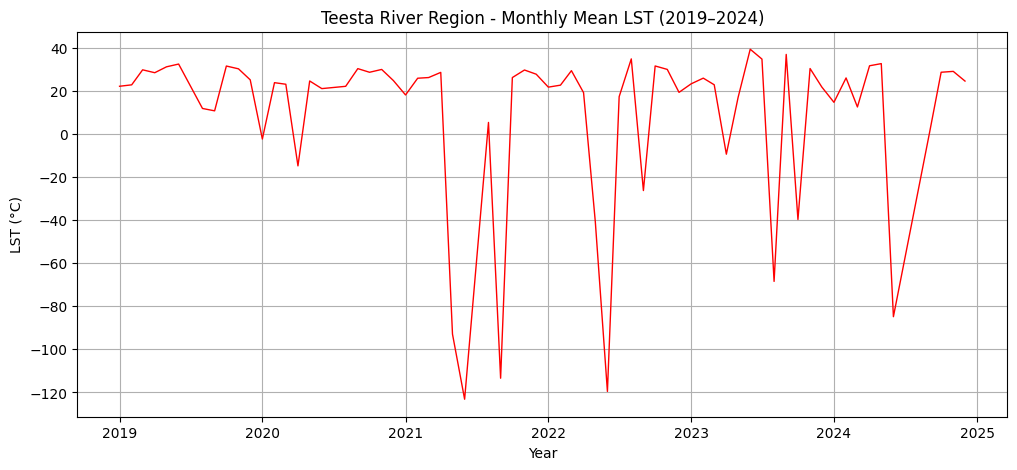

In [27]:
# time series trend:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(lst_df['date'], lst_df['LST_C'], color='red', linewidth=1)

plt.title("Teesta River Region - Monthly Mean LST (2019–2024)")
plt.xlabel("Year")
plt.ylabel("LST (°C)")
plt.grid(True)
plt.show()


In [28]:
# ^unrealistic value need to fix

In [29]:
# MODIS LST
modis = (
    ee.ImageCollection('MODIS/061/MOD11A2')
    .filterBounds(aoi)
    .filterDate(start_date, end_date)
)

# to celc
def modis_lst_celsius(image):
    lst = image.select('LST_Day_1km')\
    .multiply(0.02)\
    .subtract(273.15)\
    .rename('LST_C')

    return image.addBands(lst).select('LST_C')

modis_lst = modis.map(modis_lst_celsius)


In [30]:
# monthly modis

years = ee.List.sequence(2019, 2024)
months = ee.List.sequence(1, 12)

def build_modis_monthly():

    def per_year(year):
        year = ee.Number(year)

        def per_month(month):
            month = ee.Number(month)

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            img = modis_lst.filterDate(start, end) \
                           .median() \
                           .clip(aoi)

            return img.set({
                'year': year,
                'month': month,
                'system:time_start': start.millis()
            })

        return months.map(per_month)

    return ee.ImageCollection(years.map(per_year).flatten())

modis_monthly = build_modis_monthly()



In [31]:
# modis mean LST
def extract_modis_mean(image):

    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000,   # MODIS resolution
        maxPixels=1e13
    )

    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')

    lst_value = ee.Algorithms.If(
        mean_dict.contains('LST_C'),
        mean_dict.get('LST_C'),
        None
    )

    return ee.Feature(None, {
        'date': date,
        'MODIS_LST_C': lst_value
    })

modis_features = ee.FeatureCollection(modis_monthly.map(extract_modis_mean))

modis_df = geemap.ee_to_df(modis_features)

modis_df['date'] = pd.to_datetime(modis_df['date'])
modis_df = modis_df.dropna().sort_values('date')

modis_df.head()


,MODIS_LST_C,date
0,22.492727,2019-01-01
1,24.227117,2019-02-01
2,28.251819,2019-03-01
3,28.521607,2019-04-01
4,27.985684,2019-05-01


In [32]:
# Remove unrealistic Landsat LST values
lst_df_clean = lst_df[(lst_df['LST_C'] > 5) & (lst_df['LST_C'] < 60)]

lst_df_clean.head()


,LST_C,date
0,22.092932,2019-01-01
1,22.750488,2019-02-01
2,29.721504,2019-03-01
3,28.381503,2019-04-01
4,31.115849,2019-05-01


In [33]:
merged_clean = lst_df_clean.merge(modis_df, on='date', how='inner')

correlation_clean = merged_clean['LST_C'].corr(merged_clean['MODIS_LST_C'])
print("Clean correlation:", correlation_clean)

Clean correlation: 0.2124744135311006


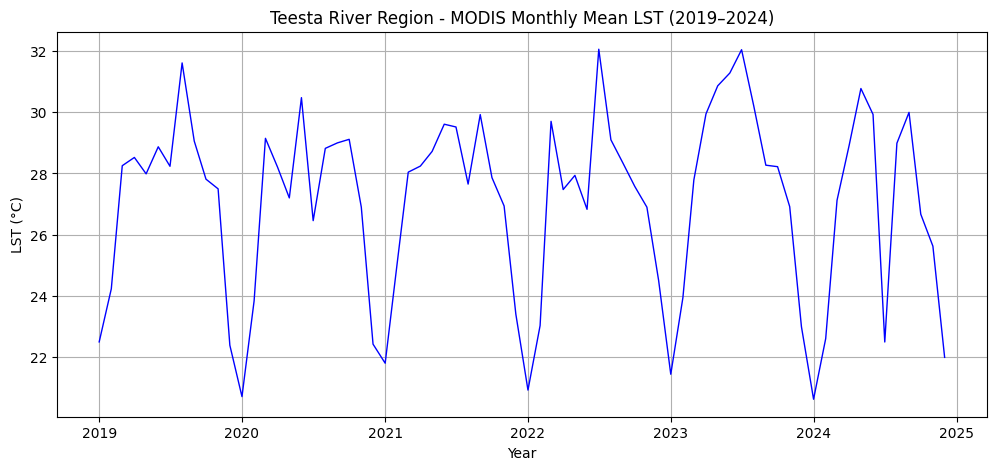

In [34]:
# plotting LST trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(modis_df['date'], modis_df['MODIS_LST_C'], color='blue', linewidth=1)

plt.title("Teesta River Region - MODIS Monthly Mean LST (2019–2024)")
plt.xlabel("Year")
plt.ylabel("LST (°C)")
plt.grid(True)
plt.show()


In [35]:
# modis vs landsat comparison merging
merged_df = lst_df.merge(modis_df, on='date', how='inner')
merged_df.head()

,LST_C,date,MODIS_LST_C
0,22.092932,2019-01-01,22.492727
1,22.750488,2019-02-01,24.227117
2,29.721504,2019-03-01,28.251819
3,28.381503,2019-04-01,28.521607
4,31.115849,2019-05-01,27.985684


In [36]:
# Remove unrealistic Landsat LST values
lst_df_clean = lst_df[(lst_df['LST_C'] > 5) & (lst_df['LST_C'] < 60)]

lst_df_clean.head()


,LST_C,date
0,22.092932,2019-01-01
1,22.750488,2019-02-01
2,29.721504,2019-03-01
3,28.381503,2019-04-01
4,31.115849,2019-05-01


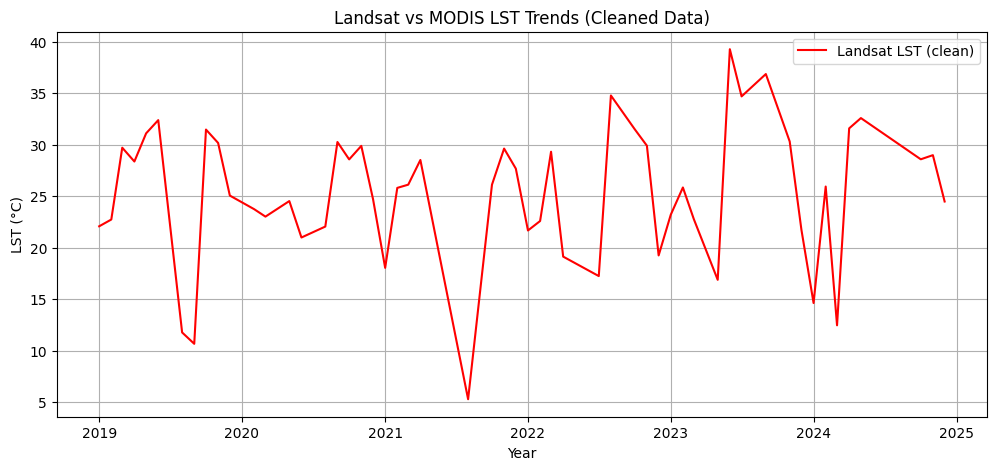

In [37]:
plt.figure(figsize=(12,5))

plt.plot(merged_clean['date'], merged_clean['LST_C'],
         label='Landsat LST (clean)', color='red')

plt.title("Landsat vs MODIS LST Trends (Cleaned Data)")
plt.xlabel("Year")
plt.ylabel("LST (°C)")
plt.legend()
plt.grid(True)
plt.show()

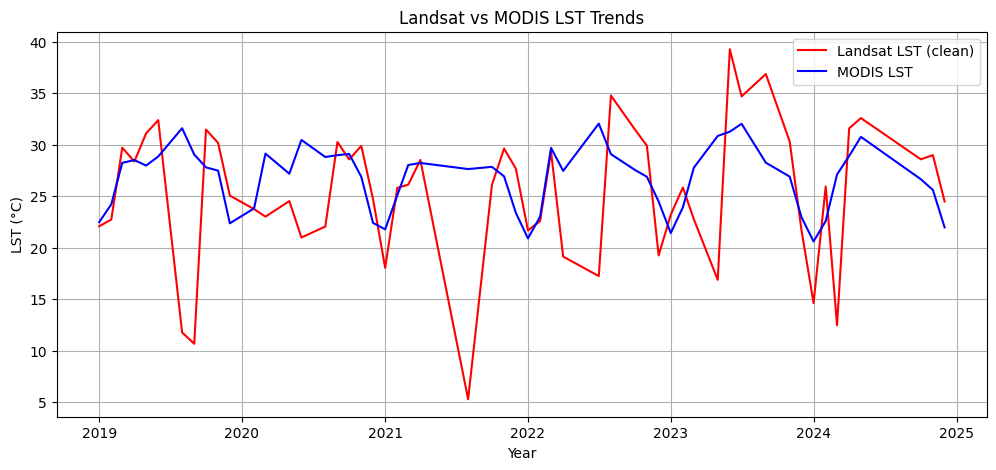

In [52]:
# plotting both sensos
plt.figure(figsize=(12,5))

plt.plot(merged_clean['date'], merged_clean['LST_C'],
         label='Landsat LST (clean)', color='red')

plt.plot(merged_clean['date'], merged_clean['MODIS_LST_C'],
         label='MODIS LST', color='blue')

plt.title("Landsat vs MODIS LST Trends")
plt.xlabel("Year")
plt.ylabel("LST (°C)")
plt.legend()
plt.grid(True)
plt.show()




In [39]:
# co-relation
merged_clean = lst_df_clean.merge(modis_df, on='date', how='inner')

correlation_clean = merged_clean['LST_C'].corr(merged_clean['MODIS_LST_C'])
print("Clean correlation:", correlation_clean)


Clean correlation: 0.2124744135311006


In [40]:
### landform analysis

In [41]:
def add_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')  # vegetation
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')  # water
    return image.addBands([ndvi, ndwi])

landsat_indices = landsat.map(add_indices)

# Median composite for stable classification
median_img = landsat_indices.median().clip(aoi)

ndvi = median_img.select('NDVI')
ndwi = median_img.select('NDWI')

# Threshold-based masks (tuned for river environments)
water_mask = ndwi.gt(0.2)                 # river/water
veg_mask = ndvi.gt(0.4)                   # vegetation/floodplain
sandbar_mask = ndvi.lt(0.2).And(ndwi.lt(0))  # bare soil/sandbar

# Convert masks to images
water = water_mask.selfMask()
vegetation = veg_mask.selfMask()
sandbar = sandbar_mask.selfMask()

# Visualization
Map = geemap.Map(center=[25.7, 89.35], zoom=9)

Map.addLayer(water, {'palette': 'blue'}, 'River/Water')
Map.addLayer(sandbar, {'palette': 'yellow'}, 'Sandbar')
Map.addLayer(vegetation, {'palette': 'green'}, 'Vegetation/Floodplain')
Map.addLayer(aoi, {}, 'AOI', False)

Map


Map(center=[25.7, 89.35], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [53]:
# Remove images with no LST_C band
def has_lst_band(image):
    band_names = image.bandNames()
    return ee.Algorithms.If(
        band_names.contains('LST_C'),
        image,
        None
    )

lst_monthly_clean = lst_monthly.map(has_lst_band, dropNulls=True)

print("Monthly images before cleaning:", lst_monthly.size().getInfo())
print("Monthly images after cleaning:", lst_monthly_clean.size().getInfo())

# single landform classification
landform_image = ee.Image(0).rename('landform_type')
landform_image = landform_image.where(water.mask(), 1)
landform_image = landform_image.where(sandbar.mask(), 2)
landform_image = landform_image.where(vegetation.mask(), 3)


def extract_lst_by_landform(image):

    lst = image.select('LST_C')

    # unmask(0) ensures all pixels in AOI have a landform_type value for grouping.
    image_with_landform = lst.addBands(landform_image.unmask(0).rename('landform_type'))

    # mean LST for each landform_type
    grouped_stats_list = image_with_landform.reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName='landform_type'),
        geometry=aoi,
        scale=30,
        maxPixels=1e13,
        tileScale=4
    ).get('groups')

    #dictionalry
    grouped_dict = ee.Dictionary(ee.List(grouped_stats_list).iterate(lambda item, current:
        ee.Dictionary(current).set(ee.String(ee.Dictionary(item).get('landform_type')), ee.Dictionary(item).get('mean')),
        ee.Dictionary()
    ))

    default_grouped_dict = ee.Dictionary({
        '1': None,
        '2': None,
        '3': None
    })


    merged_grouped_dict = default_grouped_dict.combine(grouped_dict)

    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')

    # Extract LST  from the merged dictionary
    river_mean = ee.Algorithms.If(merged_grouped_dict.contains('1'), merged_grouped_dict.get('1'), None)
    sandbar_mean = ee.Algorithms.If(merged_grouped_dict.contains('2'), merged_grouped_dict.get('2'), None)
    veg_mean = ee.Algorithms.If(merged_grouped_dict.contains('3'), merged_grouped_dict.get('3'), None)

    return ee.Feature(None, {
        'date': date,
        'River_LST': river_mean,
        'Sandbar_LST': sandbar_mean,
        'Floodplain_LST': veg_mean
    })

landform_features = ee.FeatureCollection(lst_monthly_clean.map(extract_lst_by_landform))

landform_df = geemap.ee_to_df(landform_features)

landform_df['date'] = pd.to_datetime(landform_df['date'])
landform_df = landform_df.dropna().sort_values('date')

landform_df.head()


Monthly images before cleaning: 72
Monthly images after cleaning: 67


,Sandbar_LST,date
0,22.852311,2019-01-01
1,23.545688,2019-02-01
2,29.643356,2019-03-01
3,28.486223,2019-04-01
4,31.160891,2019-05-01


Monthly images before cleaning: 72
Monthly images after cleaning: 67
Final columns: ['Sandbar_LST', 'date', 'River_LST', 'Floodplain_LST']


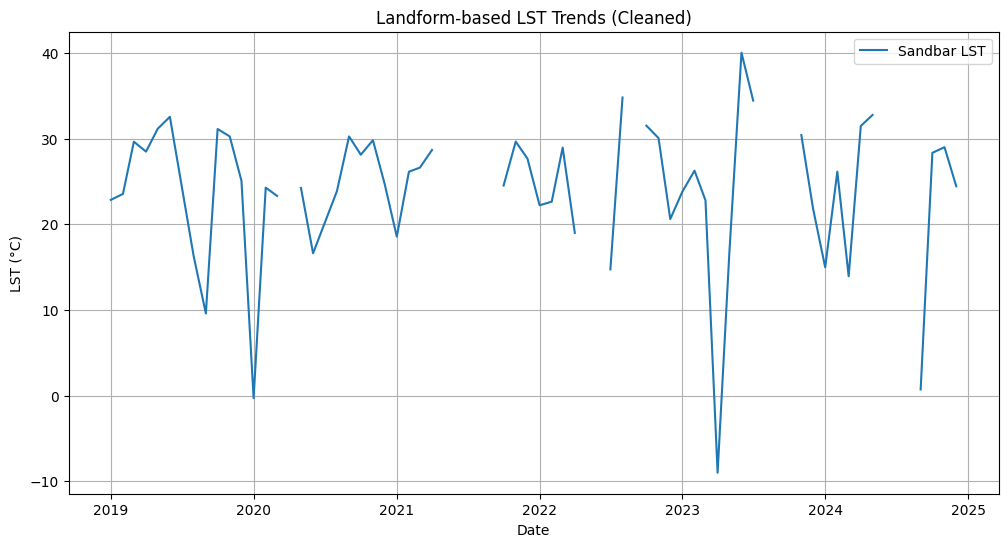

In [54]:

# Eemove images without LST_C band
def has_lst_band(image):
    band_names = image.bandNames()
    return ee.Algorithms.If(band_names.contains('LST_C'), image, None)

lst_monthly_clean = lst_monthly.map(has_lst_band, dropNulls=True)

print("Monthly images before cleaning:", lst_monthly.size().getInfo())
print("Monthly images after cleaning:", lst_monthly_clean.size().getInfo())

# Create landform classification image
landform_image = ee.Image(0).rename('landform_type')
landform_image = landform_image.where(water.mask(), 1)
landform_image = landform_image.where(sandbar.mask(), 2)
landform_image = landform_image.where(vegetation.mask(), 3)

# Extract LST by landform
def extract_lst_by_landform(image):
    lst = image.select('LST_C')

    image_with_landform = lst.addBands(
        landform_image.unmask(0).rename('landform_type')
    )

    grouped_stats_list = image_with_landform.reduceRegion(
        reducer=ee.Reducer.mean().group(
            groupField=1,
            groupName='landform_type'
        ),
        geometry=aoi,
        scale=30,
        maxPixels=1e13,
        tileScale=4
    ).get('groups')


    grouped_dict = ee.Dictionary(ee.List(grouped_stats_list).iterate(lambda item, current:
        ee.Dictionary(current).set(ee.String(ee.Dictionary(item).get('landform_type')), ee.Dictionary(item).get('mean')),
        ee.Dictionary()
    ))

    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')

    # Extract LST values using ee.Algorithms.If to explicitly check for key existence
    river_mean = ee.Algorithms.If(grouped_dict.contains('1'), grouped_dict.get('1'), None)
    sandbar_mean = ee.Algorithms.If(grouped_dict.contains('2'), grouped_dict.get('2'), None)
    veg_mean = ee.Algorithms.If(grouped_dict.contains('3'), grouped_dict.get('3'), None)

    return ee.Feature(None, {
        'date': date,
        'River_LST': river_mean,
        'Sandbar_LST': sandbar_mean,
        'Floodplain_LST': veg_mean
    })

landform_features = ee.FeatureCollection(lst_monthly_clean.map(extract_lst_by_landform))

landform_df = geemap.ee_to_df(landform_features)


import numpy as np
import pandas as pd

landform_df['date'] = pd.to_datetime(landform_df['date'])

for col in ['River_LST', 'Sandbar_LST', 'Floodplain_LST']:
    if col not in landform_df.columns:
        landform_df[col] = np.nan

# Convert to num
for col in ['River_LST', 'Sandbar_LST', 'Floodplain_LST']:
    landform_df[col] = pd.to_numeric(landform_df[col], errors='coerce')

# Remove unrealistic temperatures Valid range approx: -10°C to 70°C
for col in ['River_LST', 'Sandbar_LST', 'Floodplain_LST']:
    landform_df.loc[(landform_df[col] < -10) | (landform_df[col] > 70), col] = np.nan

landform_df = landform_df.sort_values('date').reset_index(drop=True)

print("Final columns:", landform_df.columns.tolist())
landform_df.head()


# Thermal Contrast Analysiz

if 'Sandbar_LST' in landform_df.columns and 'River_LST' in landform_df.columns:
    landform_df['Sandbar_minus_River'] = landform_df['Sandbar_LST'] - landform_df['River_LST']

if 'Floodplain_LST' in landform_df.columns and 'River_LST' in landform_df.columns:
    landform_df['Floodplain_minus_River'] = landform_df['Floodplain_LST'] - landform_df['River_LST']


cols_to_show = ['date', 'Sandbar_minus_River', 'Floodplain_minus_River']
cols_to_show = [c for c in cols_to_show if c in landform_df.columns]

landform_df[cols_to_show].head()


# Plot Clean LST Trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

if 'River_LST' in landform_df.columns and landform_df['River_LST'].notna().any():
    plt.plot(landform_df['date'], landform_df['River_LST'], label='River LST')

if 'Sandbar_LST' in landform_df.columns and landform_df['Sandbar_LST'].notna().any():
    plt.plot(landform_df['date'], landform_df['Sandbar_LST'], label='Sandbar LST')

if 'Floodplain_LST' in landform_df.columns and landform_df['Floodplain_LST'].notna().any():
    plt.plot(landform_df['date'], landform_df['Floodplain_LST'], label='Floodplain LST')

plt.title("Landform-based LST Trends (Cleaned)")
plt.xlabel("Date")
plt.ylabel("LST (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Pixel-count diagnostics by landform
def extract_pixel_counts(image):
    lst = image.select('LST_C')

    image_with_landform = lst.addBands(
        landform_image.unmask(0).rename('landform_type')
    )

    counts = image_with_landform.reduceRegion(
        reducer=ee.Reducer.count().group(
            groupField=1,
            groupName='landform_type'
        ),
        geometry=aoi,
        scale=30,
        maxPixels=1e13,
        tileScale=4
    ).get('groups')

    counts_dict = ee.Dictionary(
        ee.List(counts).iterate(
            lambda item, acc: ee.Dictionary(acc).set(
                ee.String(ee.Dictionary(item).get('landform_type')),
                ee.Dictionary(item).get('count')
            ),
            ee.Dictionary()
        )
    )

    date = ee.Date(image.get('system:time_start')).format('YYYY-MM')


    river_pixels = ee.Algorithms.If(counts_dict.contains('1'), counts_dict.get('1'), 0)
    sandbar_pixels = ee.Algorithms.If(counts_dict.contains('2'), counts_dict.get('2'), 0)
    floodplain_pixels = ee.Algorithms.If(counts_dict.contains('3'), counts_dict.get('3'), 0)

    return ee.Feature(None, {
        'date': date,
        'River_pixels': river_pixels,
        'Sandbar_pixels': sandbar_pixels,
        'Floodplain_pixels': floodplain_pixels
    })

pixel_fc = ee.FeatureCollection(
    lst_monthly_clean.map(extract_pixel_counts)
)

pixel_df = geemap.ee_to_df(pixel_fc)
pixel_df['date'] = pd.to_datetime(pixel_df['date'])
pixel_df.head()

,Floodplain_pixels,River_pixels,Sandbar_pixels,date
0,0,0,587701,2019-01-01
1,0,0,587701,2019-02-01
2,0,0,587701,2019-03-01
3,0,0,587701,2019-04-01
4,0,0,587701,2019-05-01


In [45]:

SAND_MIN = 5     # °C
SAND_MAX = 55    # °C

landform_df['Sandbar_LST_clean'] = landform_df['Sandbar_LST']

landform_df.loc[
    (landform_df['Sandbar_LST_clean'] < SAND_MIN) |
    (landform_df['Sandbar_LST_clean'] > SAND_MAX),
    'Sandbar_LST_clean'
] = np.nan

# drop rows where sandbar is invalid
sandbar_df = landform_df[['date', 'Sandbar_LST_clean']].dropna()

print("Removed values:",
      landform_df['Sandbar_LST'].count() - sandbar_df['Sandbar_LST_clean'].count())


Removed values: 3


In [46]:
# Seasonal aggregation

df = landform_df.copy()

df['month'] = pd.to_datetime(df['date']).dt.month

# Example season definition
df['season'] = np.where(df['month'].isin([6,7,8,9]), 'Monsoon', 'Dry')

seasonal_stats = (
    df.dropna(subset=['Sandbar_LST_clean'])
      .groupby('season')['Sandbar_LST_clean']
      .agg(['mean', 'std', 'count'])
      .reset_index()
)

seasonal_stats


,season,mean,std,count
0,Dry,25.628380,4.620541,42
1,Monsoon,24.641083,11.639736,12


In [47]:
# Summary statistics

summary = pd.DataFrame({
    'Overall_mean_LST': [df['Sandbar_LST_clean'].mean()],
    'Overall_SD_LST': [df['Sandbar_LST_clean'].std()],
    'Overall_n': [df['Sandbar_LST_clean'].count()],
    'Dry_mean_LST': [seasonal_stats.loc[seasonal_stats['season']=='Dry','mean'].values[0]],
    'Dry_SD_LST': [seasonal_stats.loc[seasonal_stats['season']=='Dry','std'].values[0]],
    'Dry_n': [seasonal_stats.loc[seasonal_stats['season']=='Dry','count'].values[0]],
    'Monsoon_mean_LST': [seasonal_stats.loc[seasonal_stats['season']=='Monsoon','mean'].values[0]],
    'Monsoon_SD_LST': [seasonal_stats.loc[seasonal_stats['season']=='Monsoon','std'].values[0]],
    'Monsoon_n': [seasonal_stats.loc[seasonal_stats['season']=='Monsoon','count'].values[0]],
})

summary


,Overall_mean_LST,Overall_SD_LST,Overall_n,Dry_mean_LST,Dry_SD_LST,Dry_n,Monsoon_mean_LST,Monsoon_SD_LST,Monsoon_n
0,25.408981,6.693761,54,25.62838,4.620541,42,24.641083,11.639736,12


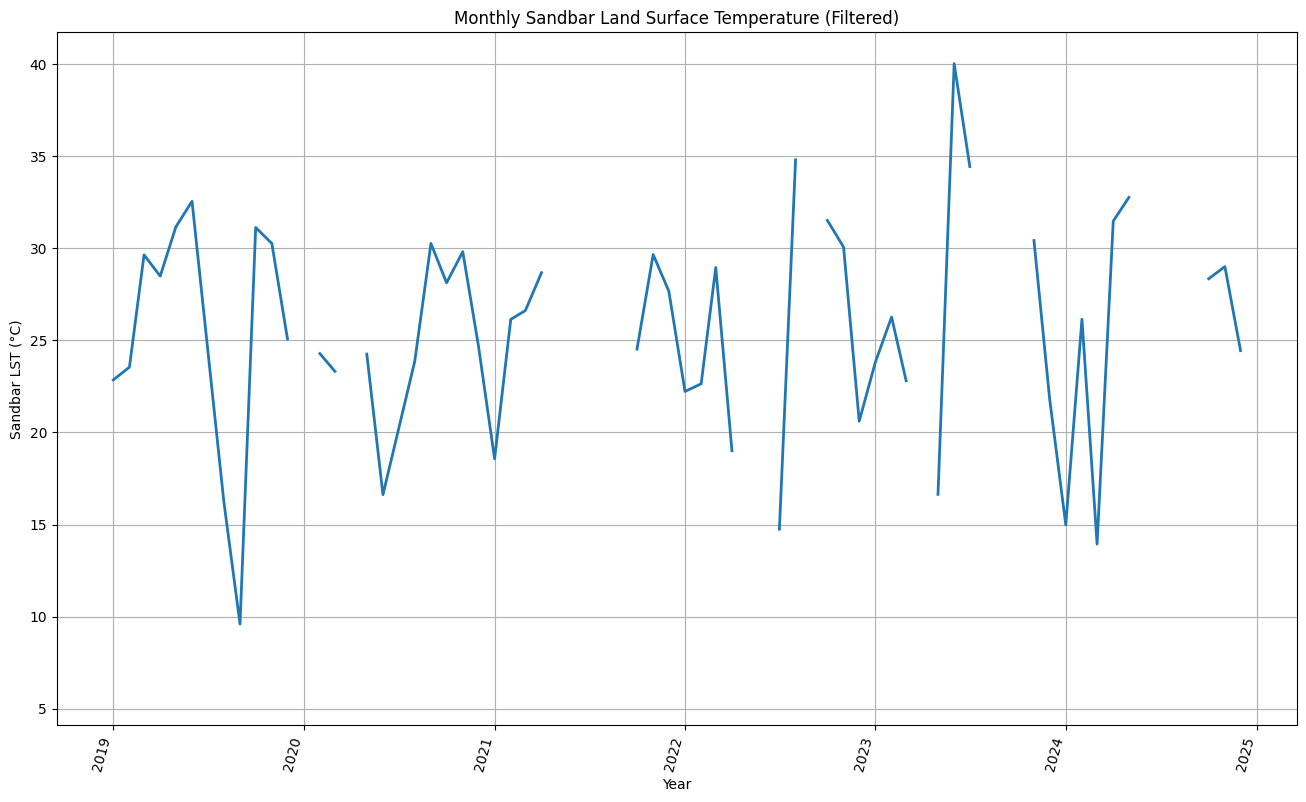

In [48]:
plt.figure(figsize=(16,9))
plt.plot(df['date'], df['Sandbar_LST_clean'], lw=2)
plt.title("Monthly Sandbar Land Surface Temperature (Filtered)")
plt.xlabel("Year")
plt.xticks(rotation=75, ha='right')
plt.ylabel("Sandbar LST (°C)")
plt.grid(True)
plt.show()


<Figure size 1600x900 with 0 Axes>

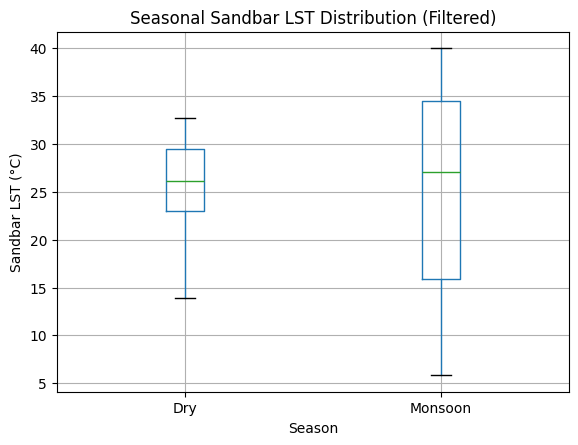

In [49]:
plt.figure(figsize=(16,9))
df_clean = df.dropna(subset=['Sandbar_LST_clean'])

df_clean.boxplot(
    column='Sandbar_LST_clean',
    by='season',
    grid=True
)

plt.title("Seasonal Sandbar LST Distribution (Filtered)")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel("Sandbar LST (°C)")
plt.show()
